# KoELECTRA

- 깃헙 블로그 주소:  https://github.com/monologg/KoELECTRA


- ELECTRA는 Replaced Token Detection, 즉 generator에서 나온 token을 보고 discriminator에서 "real" token인지 "fake" token인지 판별하는 방법으로 학습을 합니다. 이 방법은 모든 input token에 대해 학습할 수 있다는 장점을 가지며, BERT 등과 비교했을 때 더 좋은 성능을 보였습니다.

- KoELECTRA는 34GB의 한국어 text로 학습하였고, 이를 통해 나온 KoELECTRA-Base와 KoELECTRA-Small 두 가지 모델을 배포하게 되었습니다.

- KoELECTRA는 Wordpiece 사용, 모델 s3 업로드 등을 통해 ***OS 상관없이 Transformers 라이브러리만 설치하면 곧바로 사용할 수 있습니다***.₩

- 참고 블로그 : https://heegyukim.medium.com/huggingface-koelectra%EB%A1%9C-nsmc-%EA%B0%90%EC%84%B1%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8%ED%95%99%EC%8A%B5%ED%95%98%EA%B8%B0-1a23a0c704af

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from transformers import ElectraModel, ElectraTokenizer, ElectraForPreTraining
from transformers import AutoTokenizer, AutoModelForSequenceClassification, ElectraForSequenceClassification, AdamW
from tqdm.notebook import tqdm



In [3]:
# !pip install pytorch_lightning

In [6]:
# import pytorch_lightning as pl
# from pytorch_lightning import loggers as pl_loggers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
#드라이브 연동
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# # Torch GPU 설정
# device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device(device_type)

# 데이터 전처리

In [8]:
data1 = pd.read_excel("/content/drive/MyDrive/Data/한국어_단발성_대화_데이터셋.xlsx", engine='openpyxl')
data2 = pd.read_excel("/content/drive/MyDrive/Data/한국어_연속적_대화_데이터셋.xlsx", engine='openpyxl')

In [9]:
data1 = data1[['Sentence','Emotion']]
data2 = data2[['Unnamed: 1','Unnamed: 2']]
data2.drop([0],axis=0,inplace=True)
data2.rename(columns={'Unnamed: 1':'Sentence','Unnamed: 2':'Emotion'},inplace=True)
data2.replace('ㅍ','공포',inplace=True)
data2.replace(['분','분ㄴ'],'분노',inplace=True)
data2.replace(['ㅈ중립','중림','ㄴ중립','줄'],'분노',inplace=True)


<ipython-input-9-8cd63477b64b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.drop([0],axis=0,inplace=True)
<ipython-input-9-8cd63477b64b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.rename(columns={'Unnamed: 1':'Sentence','Unnamed: 2':'Emotion'},inplace=True)
<ipython-input-9-8cd63477b64b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.replace('ㅍ','공포',inplace=True)
<ipython-input-9-8cd63477b64b>:6: SettingW

In [11]:
# nan 제거
data2 = data2.dropna(how='any')

In [12]:
data1['Emotion'].unique()
data2['Emotion'].unique()

array(['분노', '혐오', '중립', '놀람', '행복', '공포', '슬픔'], dtype=object)

In [13]:
data = pd.concat([data1,data2])
data.sample(n=10)

,Sentence,Emotion
6788,장원삼이 60억이라니 ............,놀람
55488,살이 많이 빠지신 것 같네요.,중립
42514,자꾸 말씀 빙빙 돌리실래요? 진짜로 나 미치고 환장하는 꼴 보고 싶으세요?,분노
2929,근데 헤어지기도 두려워요....,공포
9402,가자. 나 정말 대단한걸 발견했어.,중립
9037,대통령하고 진짜 많이 닮았었네요?,놀람
14762,수술도 잘 됐구요. 회복이 빨라요. ...좀 더 자요.,중립
35926,아베 마누라 아프리카로 팔아야 ?,혐오
41029,"내 게스트 출연 조건이 하나 있는데, 내 코너 원고는 무조건 자기가 써야 돼.",중립
23508,일하는데? 글쎄.. 이제부터 잘 구해봐야지.,중립


In [14]:
data.drop_duplicates(['Sentence','Emotion'],inplace=True) # 중복행 제거
len(data)

90116

In [15]:
num_labeling_dics ={
    '공포': 0,
    '놀람': 1,
    '분노': 2,
    '슬픔': 3,
    '중립': 4,
    '행복': 5,
    '혐오': 6
  }

In [16]:
# 감정 -> 숫자 레이블링
for label_class in num_labeling_dics:
    data.loc[(data['Emotion'] == label_class), 'Emotion'] = num_labeling_dics[label_class]

In [17]:
# data_list = []
# for q, label in zip(data['Sentence'], data['Emotion'])  :
#     check_data = []
#     check_data.append(q)
#     check_data.append(str(label))
#     data_list.append(check_data)

In [18]:
texts = []
labels = []
for q, label in zip(data['Sentence'], data['Emotion'])  :
    texts.append(q)
    labels.append((label))

In [19]:
texts

['언니 동생으로 부르는게 맞는 일인가요..??',
 '그냥 내 느낌일뿐겠지?',
 '아직너무초기라서 그런거죠?',
 '유치원버스 사고 낫다던데',
 '근데 원래이런거맞나요',
 ' 남자친구가 떠날까봐요',
 '이거 했는데 허리가 아플수도 있나요? ;;',
 '내가불안해서꾸는걸까..',
 ' 일주일도 안 남았당...ㅠㅠ',
 '약은 최대한 안먹으려고 하는데좋은 음시있나요?0',
 ' 구직활동 하면서 남는시간은 뭘로 활용해야 되지..',
 '괜찮은분 같아서 괜히 조급해지네요 ㅜ',
 ' 제가 스타일을 바꾸면 더 어색하게만 변할것같아서 ㅠ0',
 '아내 있으면 여자 있는 술집가면 법 적으로 문제있나요?',
 ' 한소리들을지.... 도와주세요',
 '도와주실분 없나요..',
 '그냥 잡다한거말고학업에 관련된거 듣는게 더 좋은가요?',
 ' 가격은 반값....이거 질이 다른건가요??',
 '마지막에 말씀 드렸던대로 글은 이제 내릴게요의도치않게 실시간베스트글에 올라가서 남친이 볼거 같아서요 ㅠㅠ',
 '화장품회사다보니, 젊은 여자들이 많은거 같은데 걱정이네요..',
 ' 몸무게 1키로찌는건 아니겠죠?',
 'o자 다리 많이 심한가요?',
 ' 안하는게 나을까요??',
 '그정도로 더러운가요.........',
 ' 보통 가진통도 이렇게 오래가나요?',
 '여자가 술취해서 먼저 전화하는거 짜증나요???',
 '걱정이 큽니다',
 '이거 무슨 증상이죠??ㅜㅜ',
 ' 다름 아니라 제동생 걱정 입니다',
 '아무래도 무리겠죠?',
 '애인으로써 정말 걱정됩니다',
 '이러다 일주일전에 나오는거 아닌가몰라요',
 '경고먹을까 고민0',
 '극도로 예민하고 불안한 상태에요',
 ' 못받으면 어떡하죠',
 ' 안검하수도어울릴까요?',
 '근데 그게 사마귀 일수 있데요.',
 '이제 곧 내년이면 22살인 여대생입니다...요즘 고민이 있는데요...',
 ' 안하는게 좋은가요?',
 '자제할수있는 방법 뭐 없을까요??',
 '집에와서 또 운동하긴했는데지난 3주의 노력이 물거품이 될까봐

In [20]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [21]:
data['Emotion'].value_counts()

4    45641
1     9866
2     9238
3     7167
5     7015
6     5621
0     5568
Name: Emotion, dtype: int64

# WandB

In [22]:

!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=7796c68223b1a17ea032482e0514962312d0c445f167b5a663322e910d39867d
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [23]:

!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [24]:
import wandb
wandb.init(project="CJ_KoElectra", entity='tracy110410')


wandb: Currently logged in as: tracy110410. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230916_082801-ex5lpvm6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run stellar-wood-13
wandb: ⭐️ View project at https://wandb.ai/tracy110410/CJ_KoElectra
wandb: 🚀 View run at https://wandb.ai/tracy110410/CJ_KoElectra/runs/ex5lpvm6


In [25]:
# class ElectraClassification(pl.LightningModule) :
#     def __init__(self, learning_rate) :
#         super().__init__()
#         self.learning_rate = learning_rate
#         self.save_hyperparameters()

#         self.electra = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator")

#         self.metric_acc = torchmetrics.Accuracy()
#         self.metric_f1 = torchmetrics.F1(num_classes=7)
#         self.metric_rec = torchmetrics.Recall(num_classes=7)
#         self.metric_pre = torchmetrics.Precision(num_classes=7)

#         self.loss_func = nn.CrossEntropyLoss()

#     def forward(self, input_ids, attention_mask, labels=None) :
#         output = self.electra(input_ids=input_ids,
#                                 attention_mask=attention_mask,
#                                 labels=labels)
#         return output

#     def training_step(self, batch, batch_idx) :
#         '''
#         ##########################################################
#         electra forward input shape information
#         * input_ids.shape (batch_size, max_length)
#         * attention_mask.shape (batch_size, max_length)
#         * label.shape (batch_size,)
#         ##########################################################
#         '''

#         # change label shape (list -> torch.Tensor((batch_size, 1)))
#         label = batch['label'].view([-1,1])

#         output = self(input_ids=batch['input_ids'].to(device),
#                         attention_mask=batch['attention_mask'].to(device),
#                         labels=label.to(device))
#         '''
#         ##########################################################
#         electra forward output shape information
#         * loss.shape (1,)
#         * logits.shape (batch_size, config.num_labels=2)
#         '''
#         logits = output.logits

#         loss = output.loss
#         # loss = self.loss_func(logits.to(device), batch['label'].to(device))

#         softmax = nn.functional.softmax(logits, dim=1)
#         preds = softmax.argmax(dim=1)

#         self.log("train_loss", loss, prog_bar=True)

#         return {
#             'loss' : loss,
#             'pred' : preds,
#             'label' : batch['label']
#         }

#     def training_epoch_end(self, outputs, state='train') :
#         y_true = []
#         y_pred = []
#         for i in outputs :
#             y_true += i['label'].tolist()
#             y_pred += i['pred'].tolist()

#         acc = accuracy_score(y_true, y_pred)
#         prec = precision_score(y_true, y_pred)
#         rec = recall_score(y_true, y_pred)
#         f1 = f1_score(y_true, y_pred)

#         # self.log(state+'_acc', acc, on_epoch=True, prog_bar=True)
#         # self.log(state+'_precision', prec, on_epoch=True, prog_bar=True)
#         # self.log(state+'_recall', rec, on_epoch=True, prog_bar=True)
#         # self.log(state+'_f1', f1, on_epoch=True, prog_bar=True)
#         print(f'[Epoch {self.trainer.current_epoch} {state.upper()}] Acc: {acc}, Prec: {prec}, Rec: {rec}, F1: {f1}')

#     def validation_step(self, batch, batch_idx) :
#         '''
#         ##########################################################
#         electra forward input shape information
#         * input_ids.shape (batch_size, max_length)
#         * attention_mask.shape (batch_size, max_length)
#         ##########################################################
#         '''
#         output = self(input_ids=batch['input_ids'].to(device),
#                         attention_mask=batch['attention_mask'].to(device))
#         logits = output.logits
#         preds = nn.functional.softmax(logits, dim=1).argmax(dim=1)

#         labels = batch['label']
#         accuracy = self.metric_acc(preds, labels)
#         f1 = self.metric_f1(preds, labels)
#         recall = self.metric_rec(preds, labels)
#         precision = self.metric_pre(preds, labels)
#         self.log('val_accuracy', accuracy, on_epoch=True, prog_bar=True)
#         self.log('val_f1', f1, on_epoch=True, prog_bar=True)
#         self.log('val_recall', recall, on_epoch=True, prog_bar=True)
#         self.log('val_precision', precision, on_epoch=True, prog_bar=True)

#         return {
#             'accuracy' : accuracy,
#             'f1' : f1,
#             'recall' : recall,
#             'precision' : precision
#         }

#     def validation_epoch_end(self, outputs) :
#         val_acc = torch.stack([i['accuracy'] for i in outputs]).mean()
#         val_f1 = torch.stack([i['f1'] for i in outputs]).mean()
#         val_rec = torch.stack([i['recall'] for i in outputs]).mean()
#         val_pre = torch.stack([i['precision'] for i in outputs]).mean()
#         # self.log('val_f1', val_f1, on_epoch=True, prog_bar=True)
#         # self.log('val_acc', val_acc, on_epoch=True, prog_bar=True)
#         print(f'val_accuracy : {val_acc}, val_f1 : {val_f1}, val_recall : {val_rec}, val_precision : {val_pre}')


#     def configure_optimizers(self) :
#         optimizer = torch.optim.AdamW(self.electra.parameters(), lr=self.learning_rate)
#         lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

#         return {
#             'optimizer' : optimizer,
#             'lr_scheduler' : lr_scheduler
#         }

#  NSMCDataset 구성

In [26]:
class NSMCDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'label': label}


In [27]:
def check_label(label):
  if label['공포'] == 0:
    return 0
  elif label['놀람'] == 1:
    return 1
  elif label['분노'] == 2:
    return 2
  elif label['슬픔'] == 3:
    return 3
  elif label['중립'] == 4:
    return 4
  elif label['행복'] == 5:
    return 5
  elif label['혐오'] == 6:
    return 6

### nsmc-huggingface-koelectra.ipynb 토크나이저
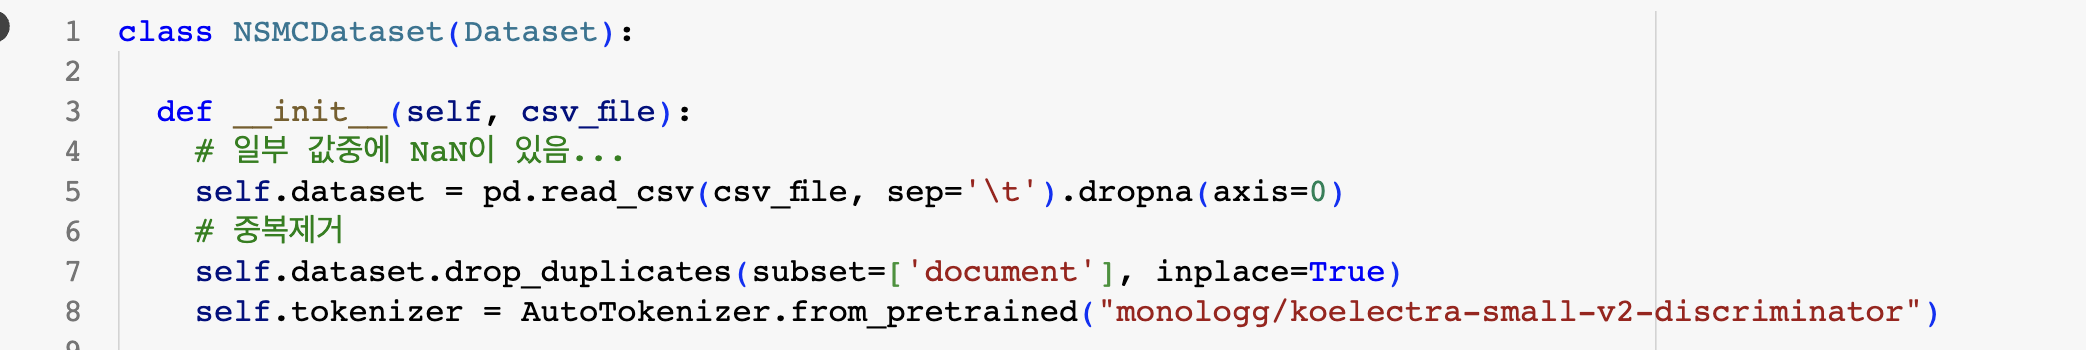

https://colab.research.google.com/drive/1JZ-pXlmgRIYHm8yPLYY68Q28l9OYAL6H?usp=sharing&source=post_page-----1a23a0c704af--------------------------------#scrollTo=f7-jRPQXz2r5

In [28]:
# KcELECTRA 모델과 토크나이저 로드
# model_name = "monologg/koelectra-base-v2-discriminator"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = ElectraForSequenceClassification.from_pretrained(model_name,num_labels=7)

from transformers import ElectraModel, ElectraTokenizer
model_name = "monologg/koelectra-base-v3-discriminator"
model = ElectraForSequenceClassification.from_pretrained(model_name, num_labels=7)
tokenizer = ElectraTokenizer.from_pretrained(model_name)



Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
model

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [30]:
# Setting parameters
max_length = 128
learning_rate = 1e-5
num_epochs = 5
batch_size = 128
random_seed=123

In [31]:
labels = torch.tensor(labels, dtype=torch.long)
dataset = NSMCDataset(texts, labels, tokenizer, max_length)

In [32]:
len(dataset)

90116

In [33]:
# config
wandb.config ={
  "learning_rate": learning_rate,
  "epochs": num_epochs,
  "batch_size": batch_size,
  "seed": random_seed
}

In [34]:
# Train / Test set 분리
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [35]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [36]:
train_data

[{'input_ids': tensor([    2,  2252,  4070,  6289,  4519,  5436,  6957, 16977,  6698, 15763,
           8214,    16,  6957, 16977,  3142, 10949,  4292,  4064,  6390,    18,
              3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,    

In [37]:
data_train = NSMCDataset(train_data, labels, tokenizer, max_length)
data_test = NSMCDataset(test_data, labels, tokenizer, max_length)

In [38]:
# 옵티마이저 및 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [39]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

In [40]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

model = model.to(device)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# 모델 재학습과 평가

In [41]:

# 모델 재학습
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()
        # 모델에 입력을 주어 예측을 생성합니다.
        outputs = model(input_ids, attention_mask=attention_mask)
        # 모델 출력에서 로짓(분류에 대한 점수)을 얻습니다.
        # 모델 예측
        logits = outputs.logits  # 최신 Transformers 라이브러리에서는 이렇게 사용할 수 있을 수 있음

        # 손실을 계산합니다.
        loss = criterion(logits, labels)
        # 역전파를 통해 그래디언트 계산
        loss.backward()
        # 옵티마이저를 사용해 가중치를 업데이트
        optimizer.step()
        # 에포크 전체 손실을 누적합니다.
        total_loss += loss.item()

    # 에포크 평균 손실 계산
    avg_loss = total_loss / len(train_dataloader)
    # 에포크별 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")

    # 모델 평가
    model.eval()
    val_total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_batch in valid_dataloader:
            # Validation 데이터 가져오기
            val_input_ids = val_batch['input_ids']
            val_attention_mask = val_batch['attention_mask']
            val_labels = val_batch['label']

            val_input_ids = val_input_ids.to(device)
            val_attention_mask = val_attention_mask.to(device)
            val_labels = val_labels.to(device)

            # 모델 예측
            val_outputs = model(val_input_ids, attention_mask=val_attention_mask)
            val_logits = val_outputs.logits

            # 손실 계산
            val_loss = criterion(val_logits, val_labels)
            val_total_loss += val_loss.item()

            # 정확도 계산
            val_preds = val_logits.argmax(dim=1)
            correct += (val_preds == val_labels).sum().item()
            total += val_labels.size(0)

    val_avg_loss = val_total_loss / len(valid_dataloader)
    val_accuracy = correct / total
    print(f"Validation Loss: {val_avg_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/5 - Avg Loss: 1.2213
Validation Loss: 0.9521 - Validation Accuracy: 0.6590
Epoch 2/5 - Avg Loss: 0.9063
Validation Loss: 0.8834 - Validation Accuracy: 0.6868
Epoch 3/5 - Avg Loss: 0.8229
Validation Loss: 0.8645 - Validation Accuracy: 0.6920
Epoch 4/5 - Avg Loss: 0.7644
Validation Loss: 0.8648 - Validation Accuracy: 0.6935
Epoch 5/5 - Avg Loss: 0.7156
Validation Loss: 0.8762 - Validation Accuracy: 0.6922


# 모델 저장 및 로드

In [42]:
# # 모델 저장
# model_save_path = "kc_bert_emotion_classifier.pth"
# torch.save(model.state_dict(), model_save_path)

# # 모델 아키텍처 생성
# loaded_model = AutoModelForSequenceClassification.from_pretrained("beomi/kcbert-base", num_labels=7)

# # 저장된 가중치 불러오기
# loaded_model.load_state_dict(torch.load(model_save_path))

# # 모델을 평가 모드로 설정
# loaded_model.eval()

#  모델 테스트 하기

In [43]:
def valid_label(label):
    if label == 0:
        return '공포'
    elif label == 1:
        return '놀람'
    elif label == 2:
        return '분노'
    elif label == 3:
        return '슬픔'
    elif label == 4:
        return '중립'
    elif label == 5:
        return '행복'
    elif label == 6:
        return '혐오'

In [44]:
# 입력 데이터 준비
input_data = [
    "만 개의 요리 레시피 감사합니다.",
    "백종원은 우리집 요리사.",
    "은근슬쩍 나올려고하네....?",
    "한심하다 한심한 인간들 득실득실해 ㅋㅋ",
    "가을이다...벌써 가을....",
    "아이폰이 답이다.......",
    "와...사진으로만으로도 압도되는데?.....",
    "내부자들 현실판 미쳤다 현실세계 ㄷㄷㄷㄷㄷ",
    "집에 가면 녹초가 된다고 너무 피곤해 요즘.....",
    "밥 먹을 힘도 없다 ㅠㅠ..",
    "너가 왠일이여???",
    "배고파서 짜증나.....",
    "아몬드브리즈 정말 맛있군"
    ]

In [45]:
import torch

# Set the device (CPU or GPU) based on the availability of GPUs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

# Tokenize and encode your input_data on the same device
input_encodings = tokenizer(input_data, padding=True, truncation=True, return_tensors="pt").to(device)

# Ensure the model is in evaluation mode
model.eval()

# Pass the input data to the model
with torch.no_grad():
    output = model(**input_encodings)

# The rest of your code for prediction remains the same
logits = output.logits
predicted_labels = logits.argmax(dim=1)

for i, input_text in enumerate(input_data):
    predicted_label = predicted_labels[i].item()
    print(f"Input: {input_text} - Predicted Label: {valid_label(predicted_label)}")


Input: 만 개의 요리 레시피 감사합니다. - Predicted Label: 행복
Input: 백종원은 우리집 요리사. - Predicted Label: 중립
Input: 은근슬쩍 나올려고하네....? - Predicted Label: 놀람
Input: 한심하다 한심한 인간들 득실득실해 ㅋㅋ - Predicted Label: 혐오
Input: 가을이다...벌써 가을.... - Predicted Label: 놀람
Input: 아이폰이 답이다....... - Predicted Label: 중립
Input: 와...사진으로만으로도 압도되는데?..... - Predicted Label: 놀람
Input: 내부자들 현실판 미쳤다 현실세계 ㄷㄷㄷㄷㄷ - Predicted Label: 놀람
Input: 집에 가면 녹초가 된다고 너무 피곤해 요즘..... - Predicted Label: 슬픔
Input: 밥 먹을 힘도 없다 ㅠㅠ.. - Predicted Label: 슬픔
Input: 너가 왠일이여??? - Predicted Label: 놀람
Input: 배고파서 짜증나..... - Predicted Label: 혐오
Input: 아몬드브리즈 정말 맛있군 - Predicted Label: 행복


In [46]:
def predict(sentence, model, tokenizer):
    # Move the model to the device
    device = next(model.parameters()).device

    input_sentence = [sentence]
    input_encodings = tokenizer(input_sentence, padding=True, truncation=True, return_tensors="pt").to(device)

    # 모델에 입력 데이터 전달
    with torch.no_grad():
        output = model(**input_encodings)

    # 예측 결과 확인
    logits = output.logits
    predicted_labels = logits.argmax(dim=1)

    # 예측 결과 출력
    for i, input_text in enumerate(input_sentence):
        predicted_label = predicted_labels[i].item()
        print(f"Input: {input_text} - Predicted Label: {valid_label(predicted_label)}")


In [47]:

#질문 무한반복하기! 0 입력시 종료
while True:
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        print("감정 분석을 종료합니다.")
        break
    predict(sentence, model, tokenizer)
    print("\n")

하고싶은 말을 입력해주세요 : 더우니까 아이스크림이 더 맛있네
Input: 더우니까 아이스크림이 더 맛있네 - Predicted Label: 행복




KeyboardInterrupt: ignored